# Backtested Returns

In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [3]:
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\TreasuryInflationPCA\root\src")
sys.path.append(r"/Users/diegoalvarez/Desktop/research/TreasuryInflationPCA/root/src")
from BackgroundFuncs import BackgroundHelperFuncs

df_pc = BackgroundHelperFuncs().get_pca()

## Analyzing PCA Signals

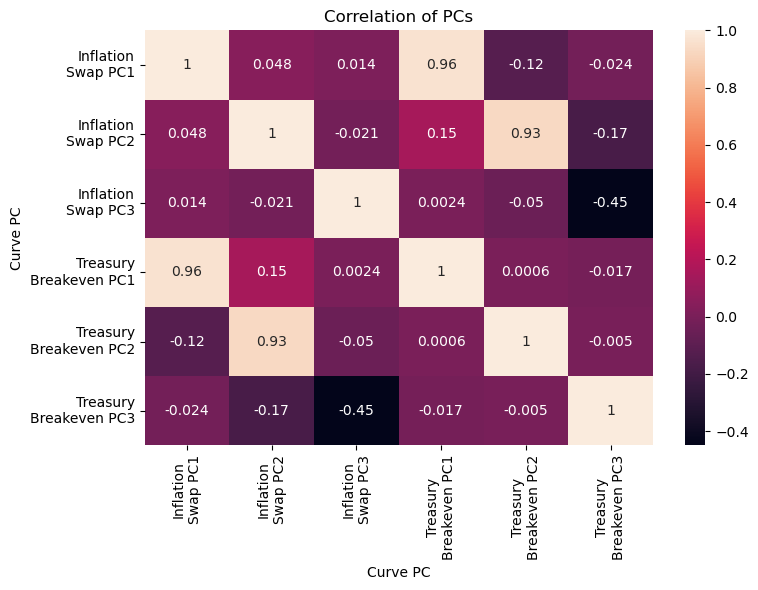

In [5]:
df_corr = BackgroundHelperFuncs().get_correlation(df_pc)
BackgroundHelperFuncs().plot_correlation(df_corr)

The first and second principal components have high correlation so trading the spread between the two will be difficult while for the third PC it will be difficult.

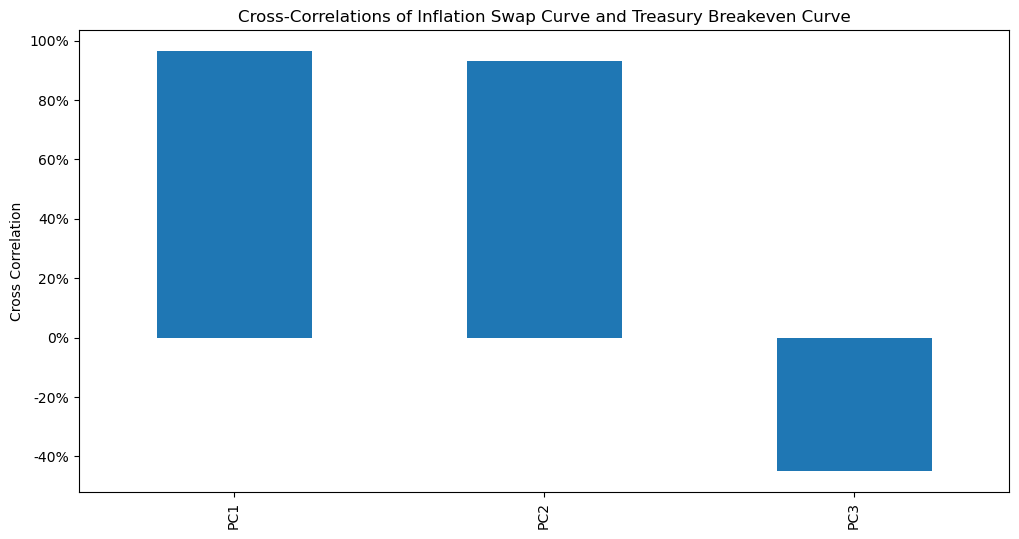

In [7]:
BackgroundHelperFuncs().plot_cross_correlations(df_corr)

Trading the difference between the PC3 will be difficult since it has such low cross-correlations. 

## Applying Signal to Treasury Returns

In [10]:
df_backtest = BackgroundHelperFuncs().get_backtest(df_pc)

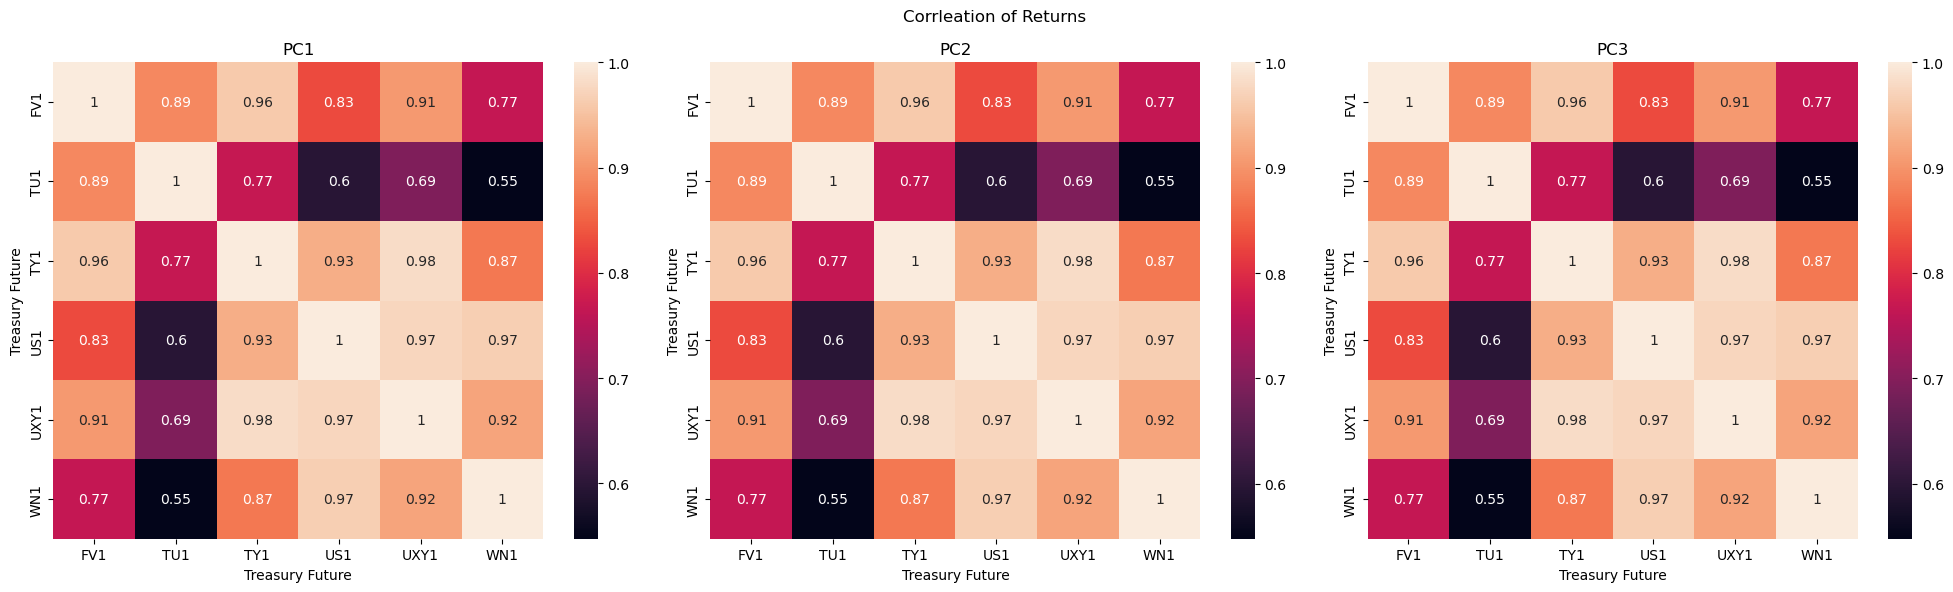

In [11]:
BackgroundHelperFuncs().plot_signal_correlation(df_backtest)

Now backtest returns

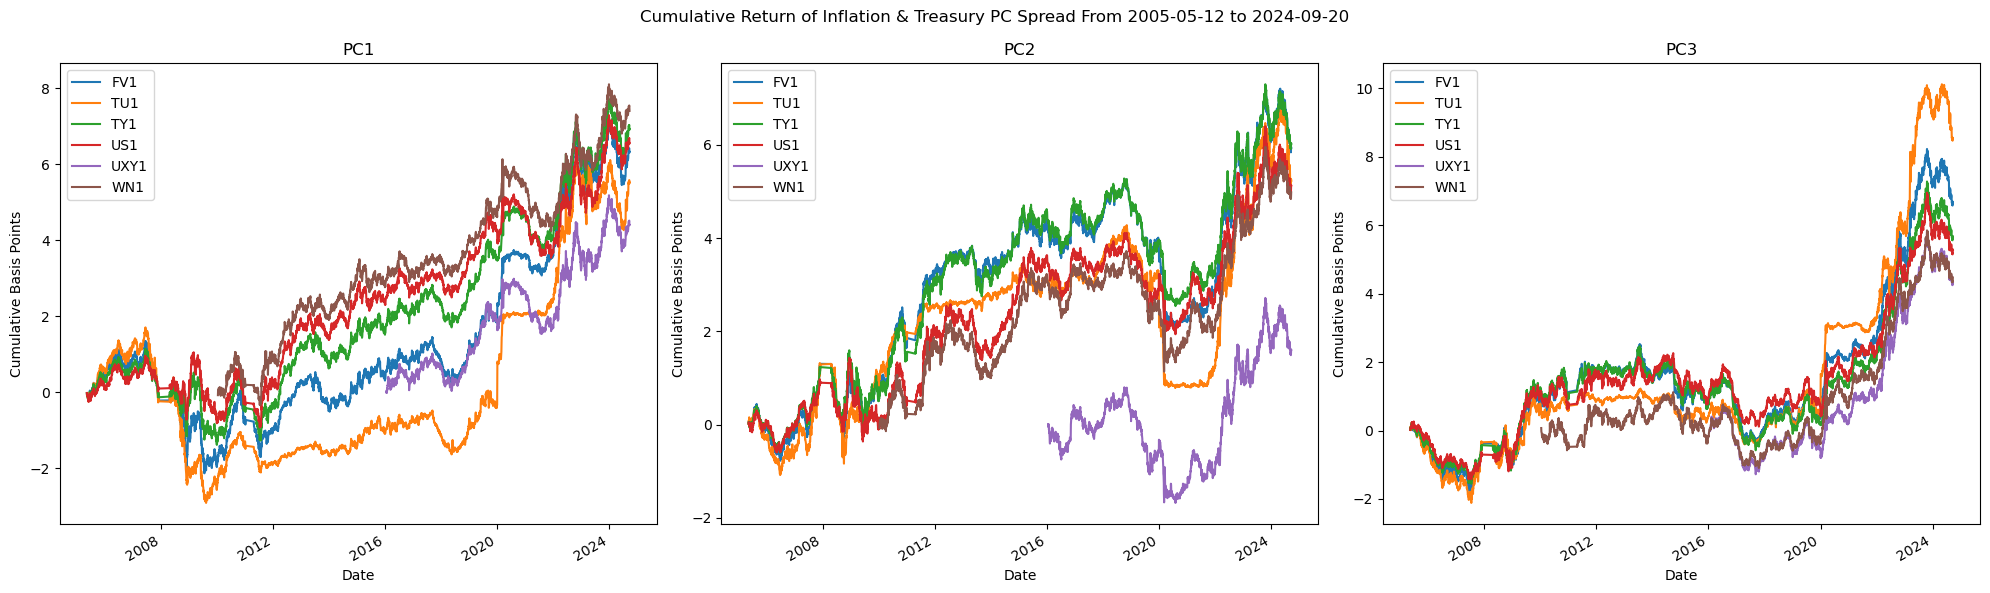

In [13]:
BackgroundHelperFuncs().plot_cum_rtn(df_backtest)

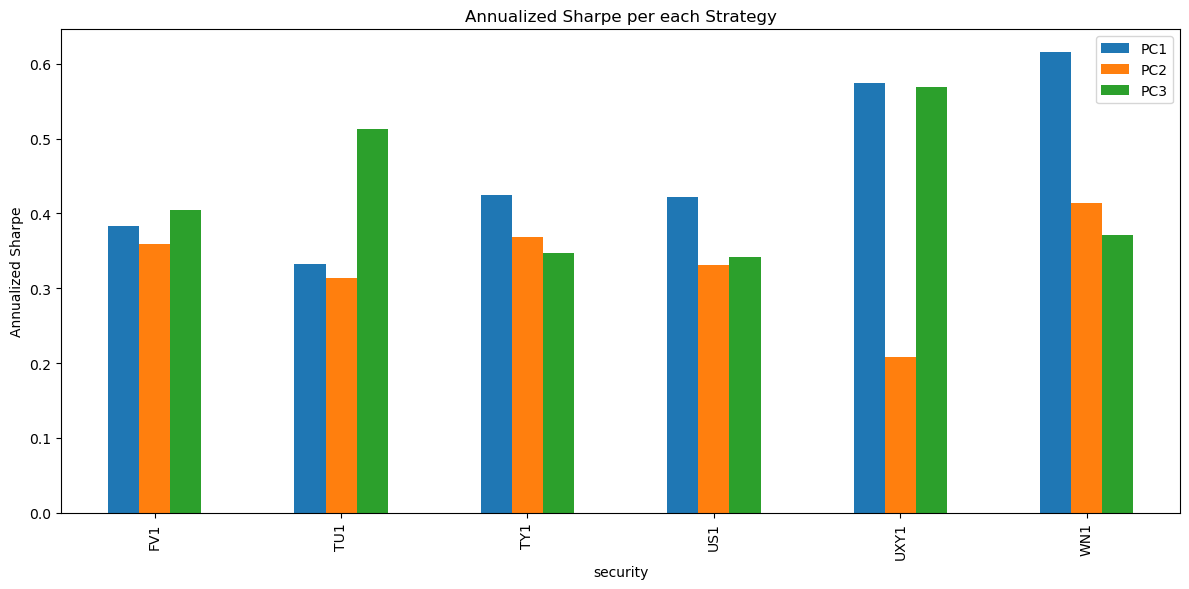

In [14]:
BackgroundHelperFuncs().plot_sharpe(df_backtest)

## Equal Risk Contribution across PCs

In [16]:
df_weight = BackgroundHelperFuncs().get_erc_weighting(df_backtest)

In [17]:
df_erc = BackgroundHelperFuncs().get_erc_rtn(df_weight)

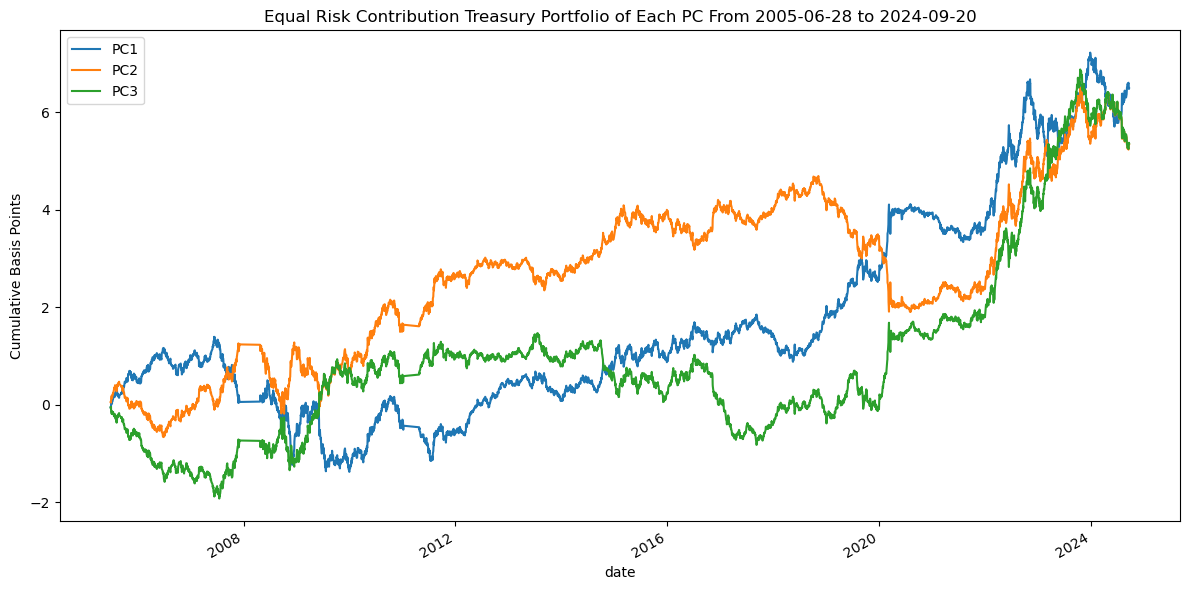

In [18]:
BackgroundHelperFuncs().plot_erc_rtn(df_erc)

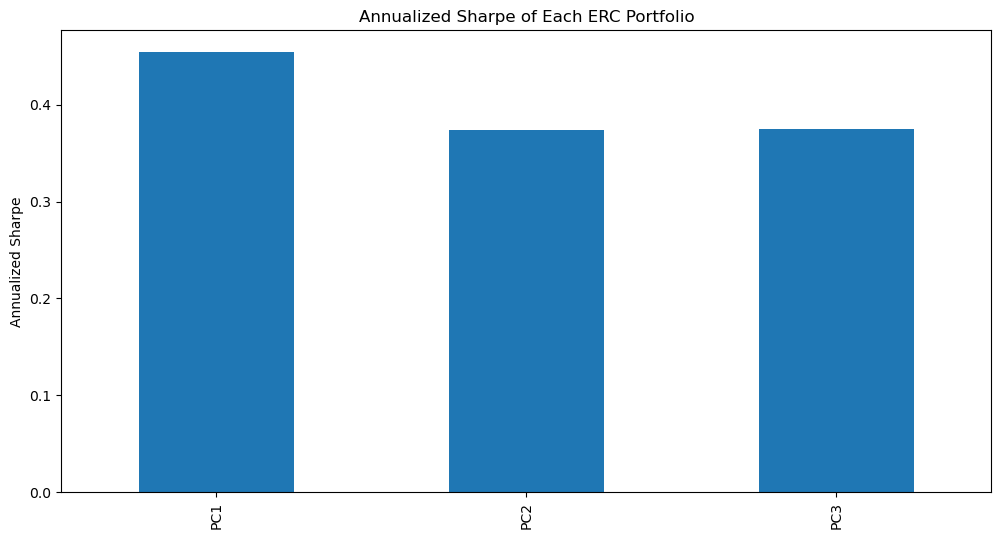

In [19]:
BackgroundHelperFuncs().plot_erc_sharpe(df_erc)

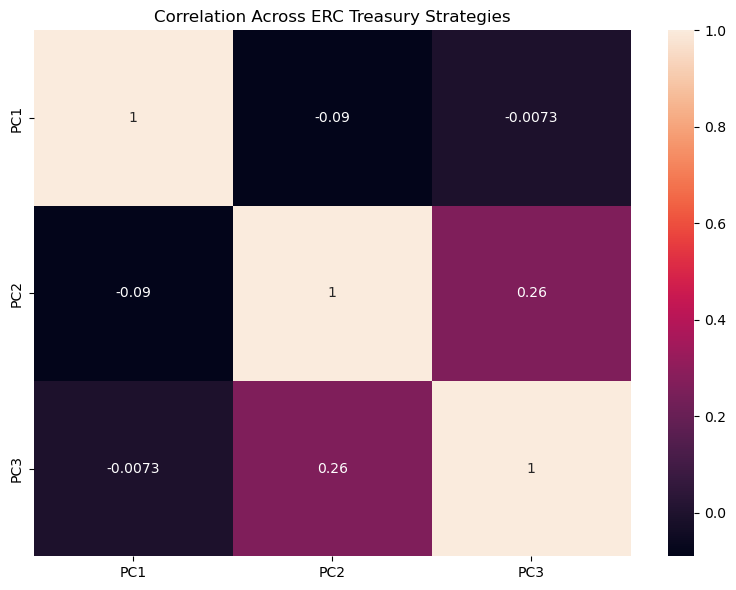

In [20]:
BackgroundHelperFuncs().plot_erc_corr(df_erc)